In [1]:
import pandas as pd
import numpy as np
import re
import gc
import tensorflow as tf
import matplotlib.pyplot as plt
import gdown
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [2]:
gdown.download("https://drive.google.com/uc?id=1-AlW7oNJHaqi3xk_9dWHUS52Dzl_FmFW", "train_data.csv", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1-AlW7oNJHaqi3xk_9dWHUS52Dzl_FmFW
From (redirected): https://drive.google.com/uc?id=1-AlW7oNJHaqi3xk_9dWHUS52Dzl_FmFW&confirm=t&uuid=7fb00531-7cb5-454a-90b1-8ec22693c06c
To: /content/train_data.csv
100%|██████████| 635M/635M [00:06<00:00, 98.3MB/s]


'train_data.csv'

In [3]:
df_train = pd.read_csv("train_data.csv", low_memory=False)

In [4]:
def clean_txt(t):
    if not isinstance(t, str):
        return ""
    t = t.lower()
    t = re.sub(r"<.*?>", " ", t)
    t = re.sub(r"http\S+|www\S+|https\S+", "", t, flags=re.MULTILINE)
    t = re.sub(r"(.)\1{2,}", r"\1\1", t)
    t = re.sub(r"[^a-z0-9\s\!\?\.\']", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

In [5]:
df_train['summary'] = df_train['summary'].fillna("")
df_train['reviewText'] = df_train['reviewText'].fillna("")
df_train['full_txt'] = df_train['summary'] + " . " + df_train['reviewText']
df_train['clean_txt'] = df_train['full_txt'].apply(clean_txt)

In [6]:
y_lbl = df_train['overall'] - 1
x_tr, x_val, y_tr, y_val = train_test_split(df_train['clean_txt'], y_lbl, test_size=0.1, random_state=42)

In [7]:
del df_train
gc.collect()

30

<h2 style="direction:rtl; text-align:right; font-family:'Vazir', 'Tahoma', sans-serif; margin-top:15px; margin-bottom:10px;">آماده سازی دنباله ها و امبدینگ</h2>
<p style="direction:rtl; text-align:justify; font-family:'Vazir', 'Tahoma', sans-serif; margin-bottom:12px;">
در این مدل، به جای فرکانس کلمات (مانند مدل پایه)، حفظ ترتیب و توالی کلمات برای ما حیاتی است. بنابراین متن را به دنباله ای از اعداد با حداکثر طول 150 کلمه و دایره لغات 20 هزارتایی تبدیل می کنیم تا در لایه Embedding، شبکه بتواند روابط معنایی و برداری کلمات را به صورت متراکم درک کند.
</p>


In [8]:
max_vocab = 20000
max_len = 150
v_lay = tf.keras.layers.TextVectorization(max_tokens=max_vocab, output_mode='int', output_sequence_length=max_len)

ds_adapt = tf.data.Dataset.from_tensor_slices(x_tr.values).batch(1024)
v_lay.adapt(ds_adapt)

<h2 style="direction:rtl; text-align:right; font-family:'Vazir', 'Tahoma', sans-serif; margin-top:15px; margin-bottom:10px;">معماری شبکه بازگشتی دوطرفه و مکانیزم توجه</h2>
<p style="direction:rtl; text-align:justify; font-family:'Vazir', 'Tahoma', sans-serif; margin-bottom:12px;">
قلب تپنده این مدل، لایه Bi-GRU است که متن را به صورت همزمان از ابتدا به انتها و از انتها به ابتدا می خواند تا کانتکست را به صورت کامل استخراج کند. بلافاصله پس از آن، لایه Attention مانند یک ذره بین هوشمند عمل کرده و به کلمات کلیدی و احساسیِ متن وزن بیشتری می دهد. این ویژگی برای نظرات طولانی آمازون بسیار کارآمد است. در نهایت ویژگی های استخراج شده فشرده شده و به لایه های متراکم نهایی ارسال می شوند.
</p>


In [9]:
input_layer = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
vec_layer = v_lay(input_layer)
emb_layer = tf.keras.layers.Embedding(input_dim=max_vocab, output_dim=100)(vec_layer)
rnn_layer = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True))(emb_layer)
att_layer = tf.keras.layers.Attention()([rnn_layer, rnn_layer])
pool_layer = tf.keras.layers.GlobalAveragePooling1D()(att_layer)
drop_layer = tf.keras.layers.Dropout(0.3)(pool_layer)
dense_layer = tf.keras.layers.Dense(32, activation='relu')(drop_layer)
output_layer = tf.keras.layers.Dense(5, activation='softmax')(dense_layer)
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

<p style="direction:rtl; text-align:justify; font-family:'Vazir', 'Tahoma', sans-serif; margin-bottom:12px;">
با توجه به قدرت بالای مدل های بازگشتی در حفظ کردن سریع داده ها، استفاده از این تکنیک الزامی است. این کال بک، دقت اعتبارسنجی را در هر ایپاک رصد کرده و در صورت عدم پیشرفت پس از دو ایپاک متوالی، آموزش را متوقف و به صورت خودکار، وزن های بهترین ایپاک را روی مدل بارگذاری می کند.
</p>


In [10]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)

In [11]:
history = model.fit(x_tr.values, y_tr.values,  validation_data=(x_val.values, y_val.values),  epochs=10,  batch_size=512,  callbacks=[early_stop],  verbose=2)

Epoch 1/10
1475/1475 - 98s - 67ms/step - accuracy: 0.6796 - loss: 0.8065 - val_accuracy: 0.7171 - val_loss: 0.7077
Epoch 2/10
1475/1475 - 94s - 64ms/step - accuracy: 0.7289 - loss: 0.6713 - val_accuracy: 0.7290 - val_loss: 0.6716
Epoch 3/10
1475/1475 - 94s - 64ms/step - accuracy: 0.7451 - loss: 0.6313 - val_accuracy: 0.7332 - val_loss: 0.6603
Epoch 4/10
1475/1475 - 141s - 96ms/step - accuracy: 0.7582 - loss: 0.5995 - val_accuracy: 0.7338 - val_loss: 0.6622
Epoch 5/10
1475/1475 - 94s - 64ms/step - accuracy: 0.7721 - loss: 0.5675 - val_accuracy: 0.7345 - val_loss: 0.6743
Epoch 6/10
1475/1475 - 94s - 63ms/step - accuracy: 0.7859 - loss: 0.5345 - val_accuracy: 0.7289 - val_loss: 0.6944
Epoch 7/10
1475/1475 - 93s - 63ms/step - accuracy: 0.8012 - loss: 0.5001 - val_accuracy: 0.7254 - val_loss: 0.7198


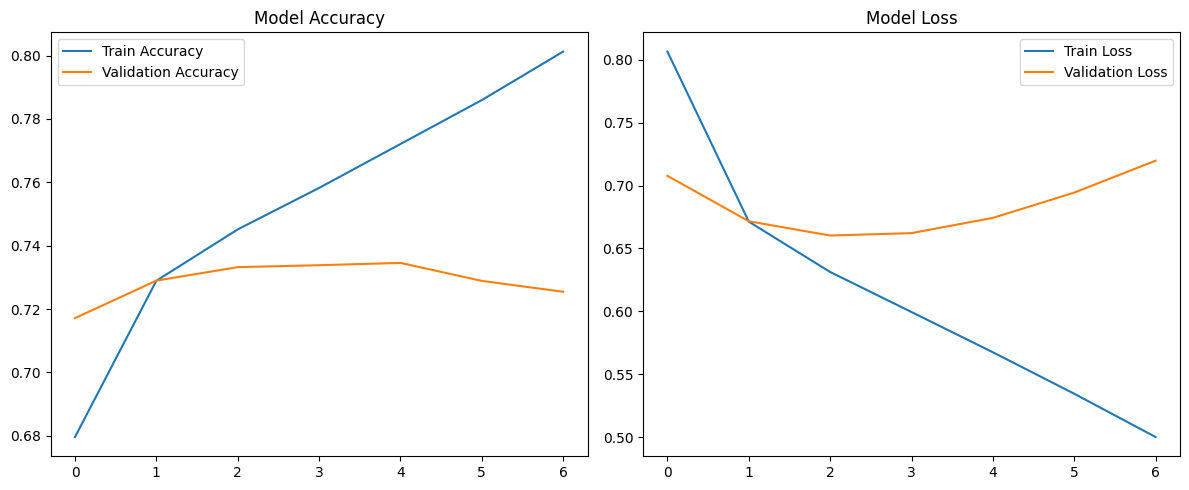

In [12]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()
plt.tight_layout()
plt.savefig('learning_curve.png')
plt.show()

In [13]:
p_raw = model.predict(x_val.values, batch_size=512)
p_cls = np.argmax(p_raw, axis=1)
f1_m = f1_score(y_val, p_cls, average='micro')

print("--- Bi-GRU + Attention F1-Micro Score ---")
print(f1_m)

model.save_weights('gru_model.weights.h5')

164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step
--- Bi-GRU + Attention F1-Micro Score ---
0.7345491388044579


<h2 style="direction:rtl; text-align:right; font-family:'Vazir', 'Tahoma', sans-serif; margin-top:15px; margin-bottom:10px;">تحلیل نتایج</h2>
<p style="direction:rtl; text-align:justify; font-family:'Vazir', 'Tahoma', sans-serif; margin-bottom:12px;">
مدل توانست به نمره F1-Micro معادل 73.45 درصد دست یابد که یک جهش چشمگیر نسبت به مدل پایه محسوب می شود. با تحلیل نمودارهای یادگیری متوجه می شویم که خطای اعتبارسنجی (Val Loss) یک الگوی U شکل به خود گرفته و در ایپاک های 3 تا 4 به کمترین حد خود رسیده است، در حالی که دقت اعتبارسنجی تا ایپاک 5 رشد خفیفی داشته است. توقف هوشمند در ایپاک 7 و بازگردانی وزن های ایپاک 5، باعث شد تا مدل دقیقاً در نقطه طلایی همگرایی متوقف شده و از حفظ کردن کورکورانه دیتا (Overfitting) در ایپاک های بعدی جلوگیری شود.
</p>
